# Predictive modeling of customer bookings

This Jupyter notebook includes Exploratory Data Analysis (EDA) and the training of a predictive machine learning model to understand the factors influencing flight-buying behaviour.

In [4]:
# import necessary libraries 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler



## Read dataset 

In [6]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [7]:
df.shape

(50000, 14)

The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

## Sanity checks 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [12]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [13]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [14]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

# Exploratory Data Analysis 

In [16]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [17]:
df.describe(include ='object')

,sales_channel,trip_type,route,booking_origin
count,50000,50000,50000,50000
unique,2,3,799,104
top,Internet,RoundTrip,AKLKUL,Australia
freq,44382,49497,2680,17872


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column, but as well as count, unique, top and freq. 

So far we can see the following observations:
- The Internet is the most popular sale channel
- The country who made (or looking to make) a booking is Australia
- The most popular trip type is RoundTrip
- The most popular route is AKLKUL

In [19]:
df.booking_complete.value_counts()


booking_complete
0    42522
1     7478
Name: count, dtype: int64

.booking_complete.value_counts() --> According to this data 15% of people have proceed with the booking. 

In [21]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

The ' .isnull()' method checks for missing values. 

In [23]:
df.duplicated().sum()

719

In [24]:
#view duplicates rows
df[df.duplicated()]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
196,5,Internet,RoundTrip,206,17,13,7,AKLKUL,Malaysia,1,0,0,8.83,0
316,5,Internet,RoundTrip,206,17,13,7,AKLKUL,Malaysia,1,0,0,8.83,0
384,5,Internet,RoundTrip,206,17,13,7,AKLKUL,Malaysia,1,0,0,8.83,0
456,1,Internet,RoundTrip,30,85,15,5,AKLKUL,Malaysia,1,0,0,8.83,1
513,3,Internet,RoundTrip,109,20,4,2,AKLKUL,Singapore,1,0,1,8.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49852,2,Internet,RoundTrip,204,6,14,2,PENTPE,Malaysia,1,0,0,4.67,0
49902,1,Mobile,RoundTrip,106,6,11,5,PENTPE,Taiwan,1,0,0,4.67,0
49934,1,Internet,RoundTrip,2,6,3,4,PENTPE,Malaysia,0,0,1,4.67,0
49944,1,Internet,RoundTrip,2,6,3,4,PENTPE,Malaysia,0,0,1,4.67,0


We realised that we have 719 duplicates, and since these are reduntant information, we have decided to drop them from or analysis 

In [26]:
df.drop_duplicates(subset=None, keep='first', inplace=False)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


## Checked for garbage value 

In [28]:
for i in df.select_dtypes(include='object').columns:
    print(df[i].value_counts())
    print('***'*10)

sales_channel
Internet    44382
Mobile       5618
Name: count, dtype: int64
******************************
trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64
******************************
route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: count, Length: 799, dtype: int64
******************************
booking_origin
Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: count, Length: 104, dtype: int64
******************************


# Split the variables between categorical and continous variables 
Since we have a mixed-type dataset, we must devide betweeen categorical and continous variables before proceeding with further analysis and visualisation. 


## *categorical variables*
- sales_channel
- trip_type
- flight_day
- route
- booking_origin 
- wants_extra_baggage
- wants_preffered_seat
- wants_in_flight_meals
- booking_complete


## *continuous variabels*
- num_passengers
- purchase_lead
- lenght_of_stay
- flight_hours
- flight_duration 



## Visualising the data

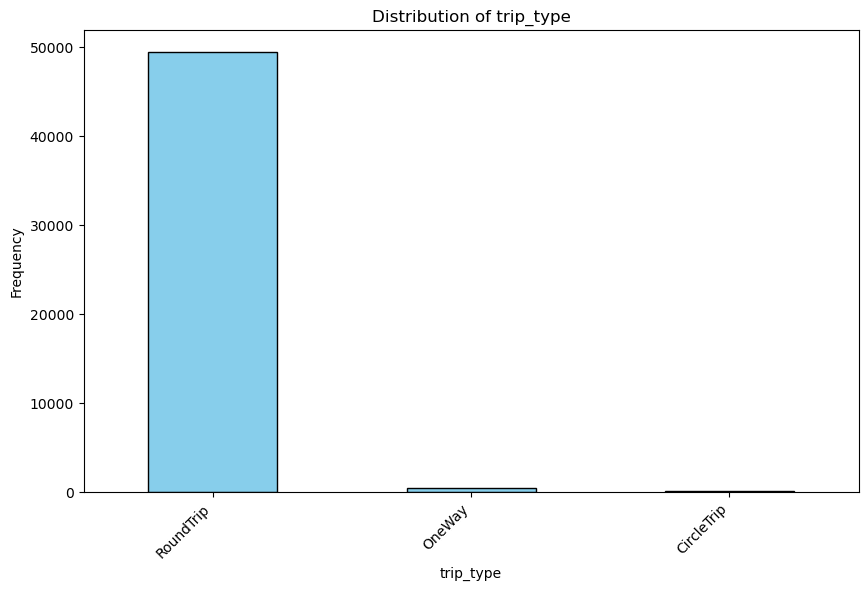

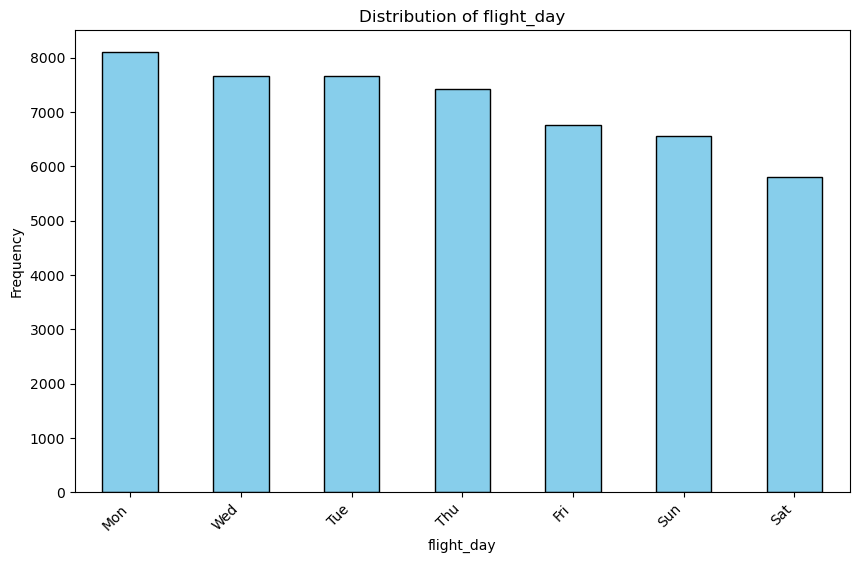

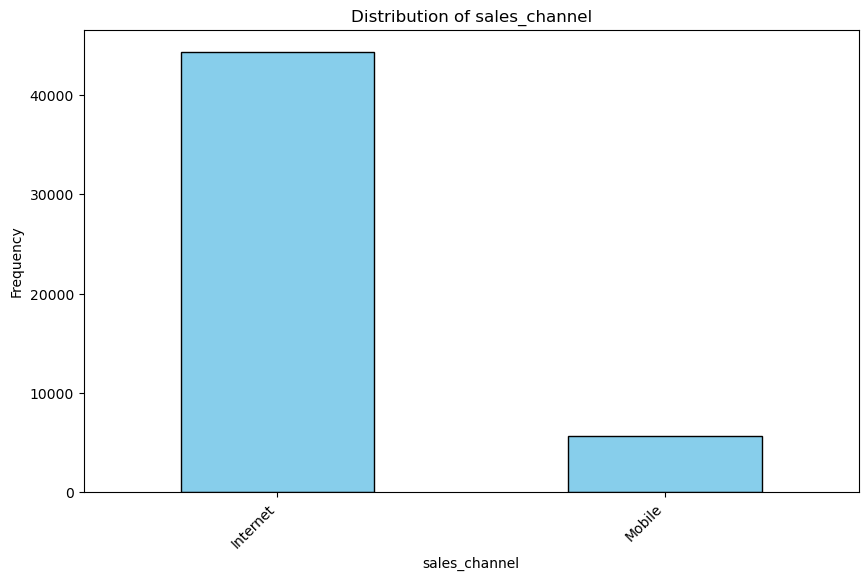

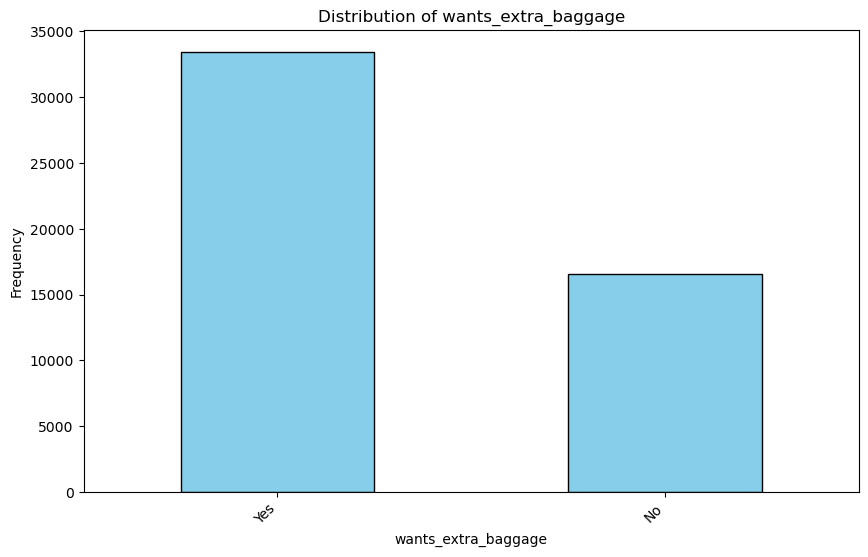

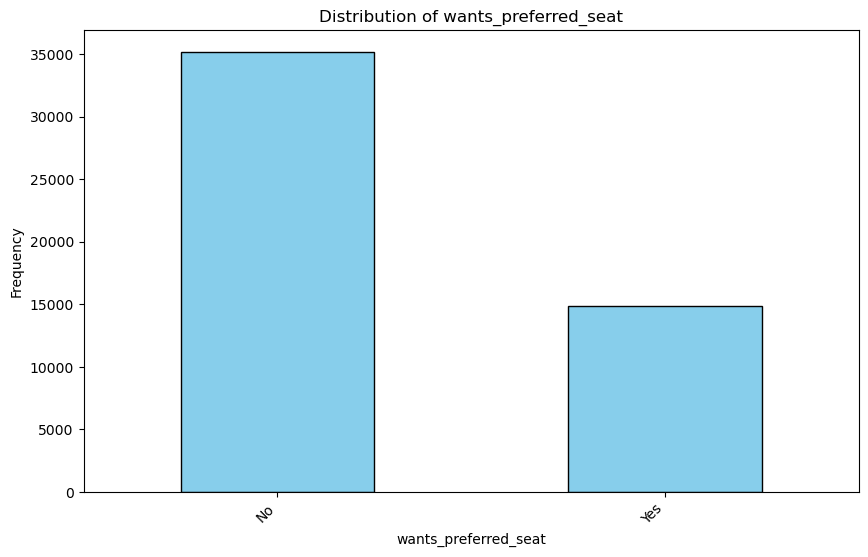

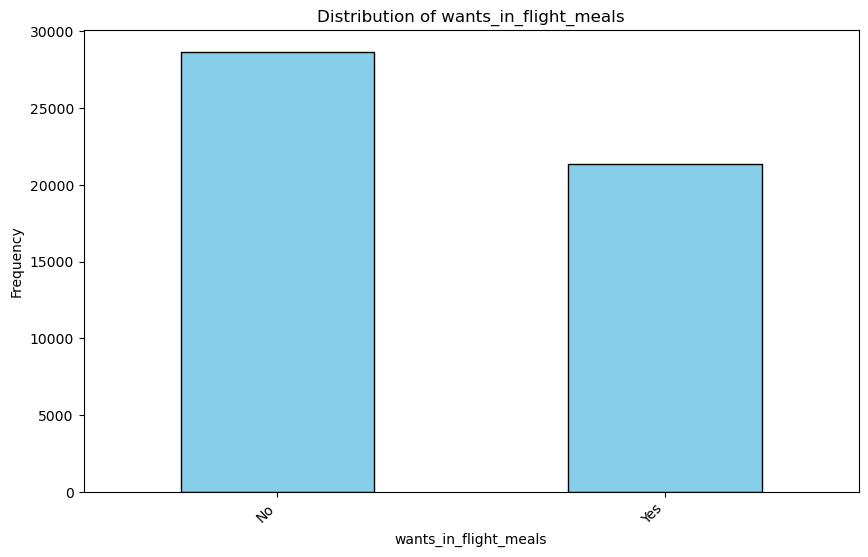

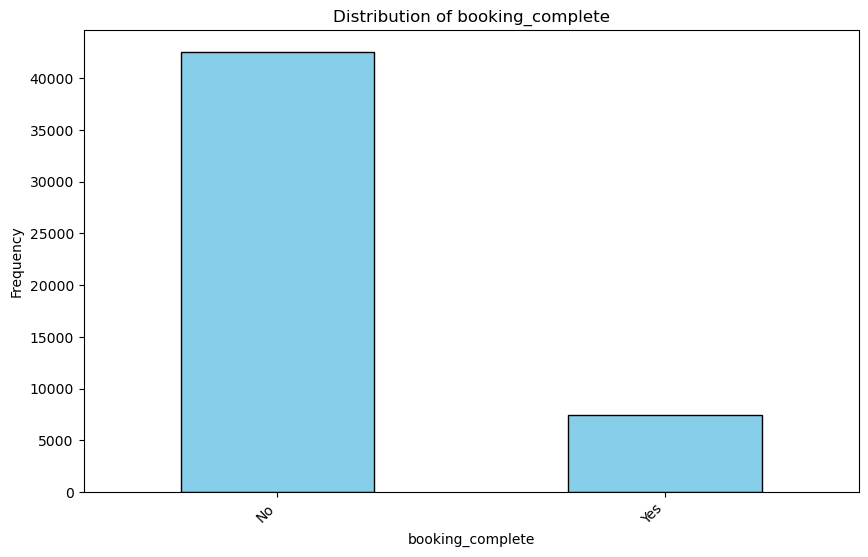

In [31]:
categorical_variables_bar = ['trip_type', 'flight_day', 'sales_channel',
                             'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'booking_complete']
# mapping the flight day
mapping_flight_day = {  
    1: "Mon",
    2: "Tue",
    3: "Wed",
    4: "Thu",
    5: "Fri",
    6: "Sat",
    7: "Sun",
}

#Creation of a bar chart
# Loop through each categorical variable to create a bar chart
for variable in categorical_variables_bar:
    plt.figure(figsize=(10, 6))

    #for binary variable replace 0 = NO and 1 = YES
    if variable in ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'booking_complete']:
        df[variable] = df[variable].replace({0: 'No', 1: 'Yes'})

    else:
        
        variable in ['flight_day']
        df[variable] = df[variable].replace(mapping_flight_day)
        
 
    # Plotting the bar chart
    df[variable].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right') 
    plt.show()



- The bar chart shows that Roundtrip is the preferred trip type, while One-Way and Circle trips are the least popular.
- Monday is the most popular day for travel.
- The internet is the preferred sales channel.
- Travelers show little interest in booking a preferred seat or selecting in-flight meals.
- Overall, only a small percentage proceed with booking the trip.

In [33]:
Continous_Var = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

Continous_Var =df[Continous_Var]

Continous_Var

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_duration
0,2,262,19,7,5.52
1,1,112,20,3,5.52
2,2,243,22,17,5.52
3,1,96,31,4,5.52
4,2,68,22,15,5.52
...,...,...,...,...,...
49995,2,27,6,9,5.62
49996,1,111,6,4,5.62
49997,1,24,6,22,5.62
49998,1,15,6,11,5.62


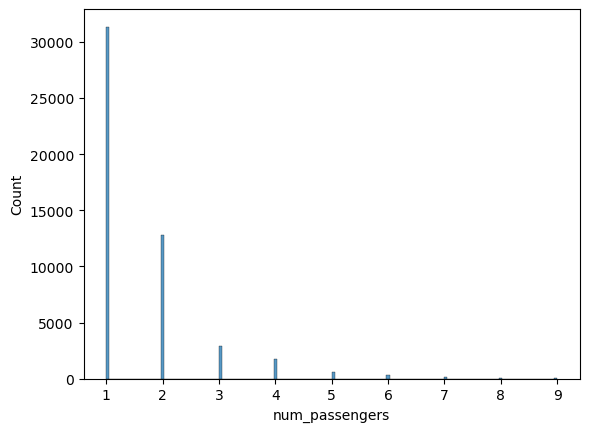

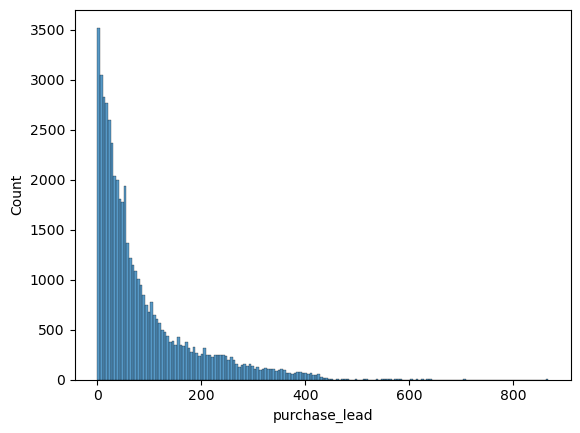

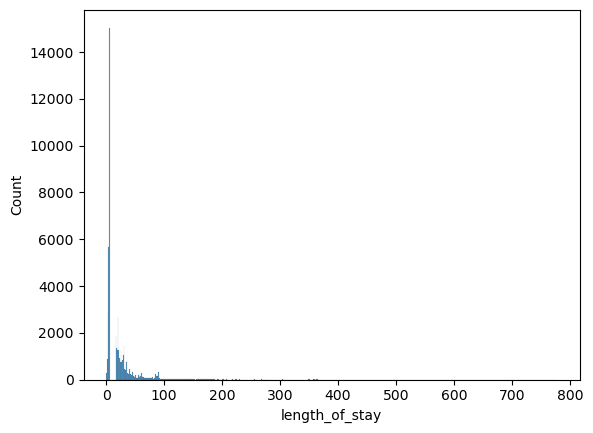

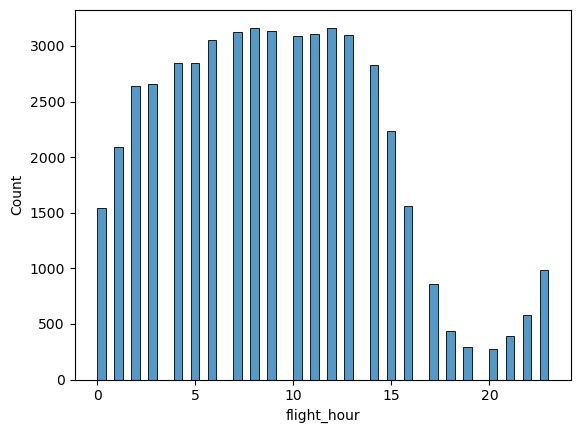

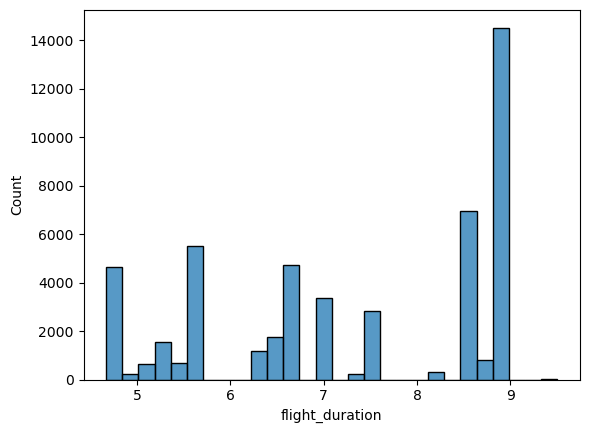

In [34]:
# histogram to evaluate the distribution 

for variable in Continous_Var.columns:
    sns.histplot(data=Continous_Var, x=variable)
    plt.show()


- The majjority of passenger travellers was one person
- and the most popular departure times were early in the morning, and afternoon while the least popular was evenings
- The most popular rtoutes preffered by the travellers had over 8.5 hours of flight


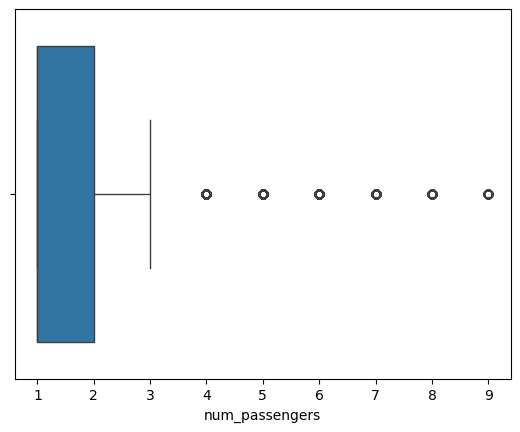

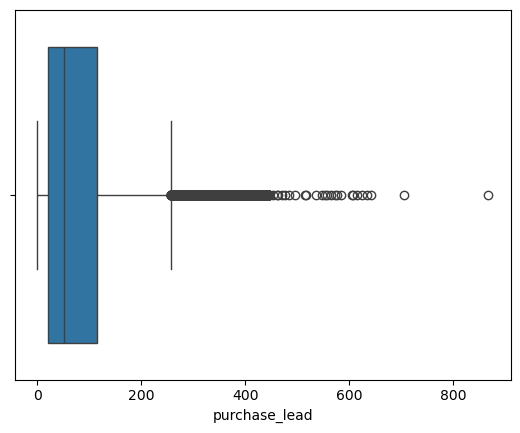

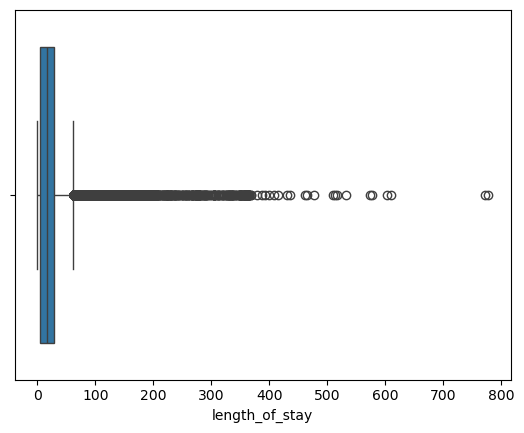

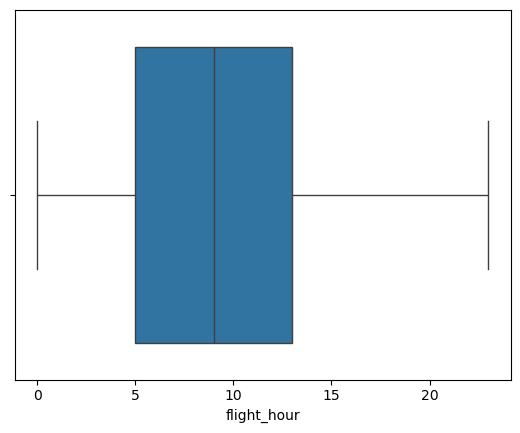

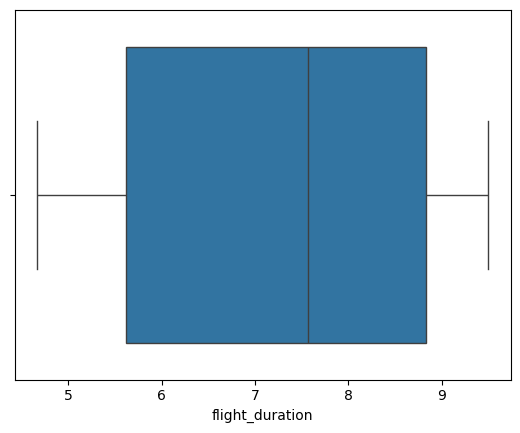

In [36]:
#BOX-PLOT to check out for outliers
for variable in Continous_Var.columns:
    sns.boxplot(data=Continous_Var, x=variable)
    plt.show()


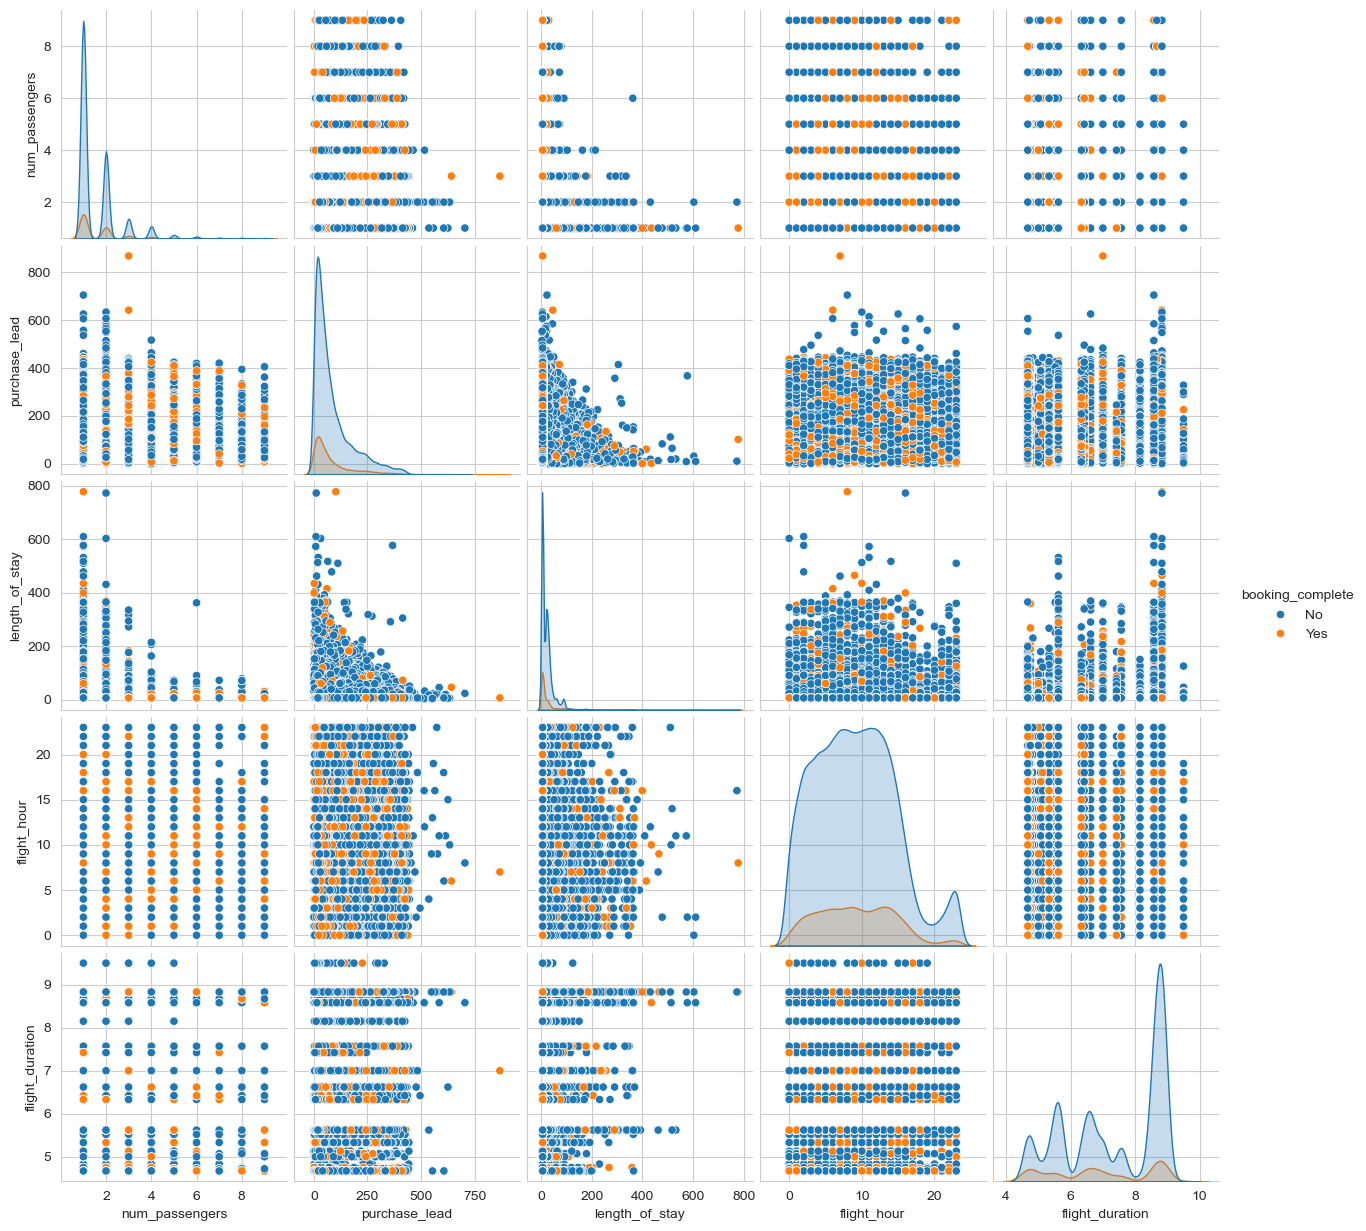

In [37]:
# Pairplot pairwise relationships between variables in our dataset
sns.set_style('whitegrid')
sns.pairplot(df, hue='booking_complete')
plt.show()

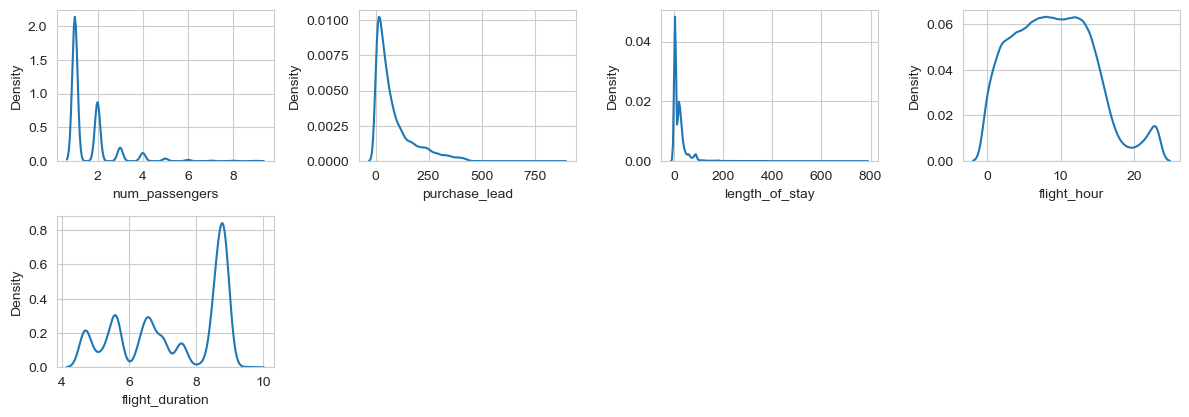

In [38]:
plt.figure(figsize=(12,8))

for i, column in enumerate (Continous_Var.columns, 1):
    plt.subplot(4,4,i)
    sns.kdeplot(data= Continous_Var, x=Continous_Var[column])
    plt.tight_layout()

As we can see from the Pairplot and the density plots above, our data are not normally distributed. Furthrmore form the box-plot we can see that the columns 'purchase_lead' and 'length_of_stay' contains lots of outliers. After carefully consideration, I decided to delete the outliers with Zscore.

In [40]:
import pandas as pd
from scipy import stats


# Function to remove outliers using Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = stats.zscore(df[columns])
    
    # Identify rows where the absolute value of Z-score is less than the threshold for all specified columns
    abs_z_scores = abs(z_scores)
    filtered_df = df[(abs_z_scores < threshold).all(axis=1)]
    
    return filtered_df

columns_with_outliers = ['purchase_lead', 'length_of_stay']

# Removing outliers
df = remove_outliers_zscore(df, columns_with_outliers, threshold=3)

# df without outliers
print(df)


       num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0                   2      Internet  RoundTrip            262              19   
1                   1      Internet  RoundTrip            112              20   
2                   2      Internet  RoundTrip            243              22   
3                   1      Internet  RoundTrip             96              31   
4                   2      Internet  RoundTrip             68              22   
...               ...           ...        ...            ...             ...   
49995               2      Internet  RoundTrip             27               6   
49996               1      Internet  RoundTrip            111               6   
49997               1      Internet  RoundTrip             24               6   
49998               1      Internet  RoundTrip             15               6   
49999               1      Internet  RoundTrip             19               6   

       flight_hour flight_d

# Mutual Information 

Mutual Information is used to identify and select the most relevant features, leading to a more efficient and effective model

In [43]:
# The X contains all the columns apart from booking_complete, as this is the target variable. 
X= df.drop('booking_complete', axis =1)
y= df.booking_complete      

#changing object dtype to int dtype 
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [44]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [45]:
#Mutual information 
mutual_info = mutual_info_classif(X, y)
mutual_info = pd.Series(mutual_info, name='Mutual Information Scores', index=X.columns)
mutual_info = mutual_info.sort_values(ascending=False)

# show the variables with their mutual information score
mutual_info 



route                    0.054046
booking_origin           0.046107
flight_duration          0.015611
length_of_stay           0.007057
wants_extra_baggage      0.006008
wants_preferred_seat     0.003388
wants_in_flight_meals    0.003184
flight_day               0.001556
num_passengers           0.001510
sales_channel            0.000000
trip_type                0.000000
purchase_lead            0.000000
flight_hour              0.000000
Name: Mutual Information Scores, dtype: float64

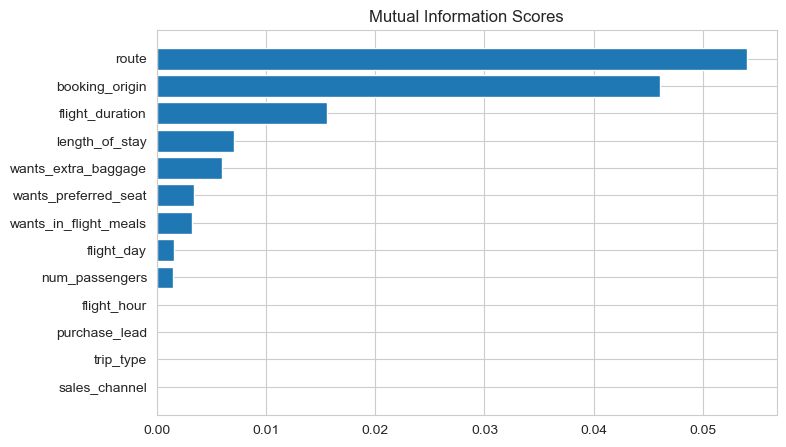

In [46]:
# plot to show mutual information scores.
def plot_mutual_info(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mutual_info(mutual_info)

From the mutual Information scores, we can see that the features dependent with booking_complete features are:
- route
- booking_origin
- flight_duration
- length_of_stay
- wants_extra_baggage
- wants_in_flight_meals
- flight_hour
- purchase_lead
- flight_day




# Feature Transformationm #

Since our continous data do not follow a normal distribution, I performed **Feature Transformationm**. This technique modify the format of data features to improve the performance of the machine learning model. 

In [50]:
# Define the continuous variables
Continous_Var = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

# Subset the dataframe
df_Con_Var = df[Continous_Var]

# Check and handle NaN values
df_Con_Var = df_Con_Var.dropna()

# Apply Min-Max Scaling
min_max_scaler = MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_Con_Var)

# Convert the scaled data back to a DataFrame with the same column names and index
df_scaled = pd.DataFrame(df_scaled, columns=Continous_Var, index=df.index)

# Replace the original selected columns in df with the scaled data
df[Continous_Var] = df_scaled


Let's check out the normalisation using density plots.

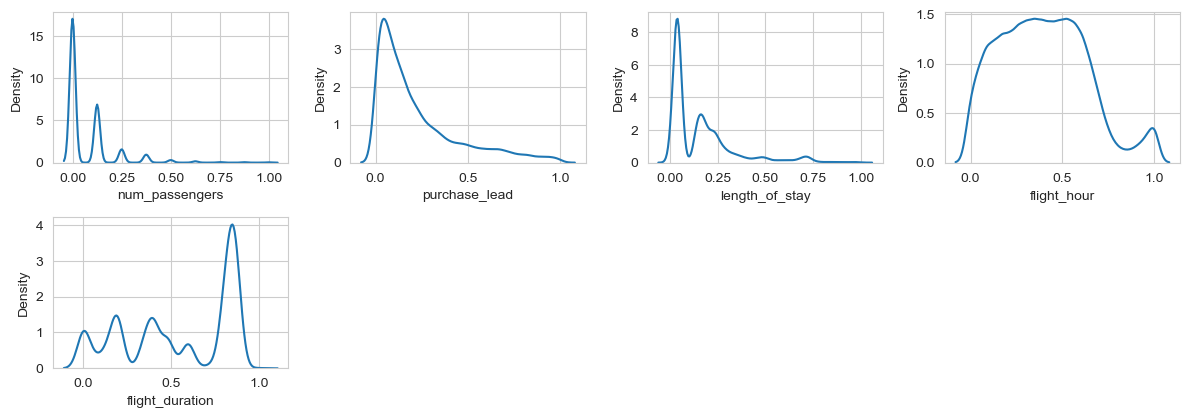

In [52]:
plt.figure(figsize=(12, 8))

# List of columns to plot
normalised_var = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

# Loop through each variable in the list
for i, column in enumerate(normalised_var, 1):
    plt.subplot(4, 4, i)
    sns.kdeplot(data=df, x=df[column])  # Use df[column] to access the data
    plt.tight_layout()

plt.show()


# Encoding

<!-- Let's transform the categorical data suitable for machine learning algorithms. **One hot Encoding** and **Label Encoding** will be used to convert the variables.

**One hot encoding** will be used to transfor the nominal variables:  'trip_type', 'route', 'booking_origin', 'sales_channel', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'booking_complete'
                             
**Label encoding** will be used to transform the ordinal variables: 'flight_day' -->

In [55]:
# # Columns to one-hot encode
one_hot_columns = [
    'sales_channel',
    'trip_type', 
    'route', 
    'booking_origin', 
    'wants_extra_baggage',
    'wants_preferred_seat',
    'wants_in_flight_meals']

# one-hot encoding using get_dummies
df = pd.get_dummies(df, columns=[col for col in one_hot_columns if col in df.columns])

# Column to be label encoded
label_column = 'flight_day'

#label encoder
le = LabelEncoder()
df[label_column] = le.fit_transform(df[label_column])


df

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,booking_complete,sales_channel_Internet,sales_channel_Mobile,trip_type_CircleTrip,...,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam,wants_extra_baggage_No,wants_extra_baggage_Yes,wants_preferred_seat_No,wants_preferred_seat_Yes,wants_in_flight_meals_No,wants_in_flight_meals_Yes
0,0.125,0.735955,0.153226,0.304348,2,0.175983,No,True,False,False,...,False,False,False,False,False,True,True,False,True,False
1,0.000,0.314607,0.161290,0.130435,2,0.175983,No,True,False,False,...,False,False,False,False,True,False,True,False,True,False
2,0.125,0.682584,0.177419,0.739130,6,0.175983,No,True,False,False,...,False,False,False,False,False,True,False,True,True,False
3,0.000,0.269663,0.250000,0.173913,2,0.175983,No,True,False,False,...,False,False,False,False,True,False,True,False,False,True
4,0.125,0.191011,0.177419,0.652174,6,0.175983,No,True,False,False,...,False,False,False,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.125,0.075843,0.048387,0.391304,2,0.196687,No,True,False,False,...,False,False,False,False,False,True,True,False,False,True
49996,0.000,0.311798,0.048387,0.173913,3,0.196687,No,True,False,False,...,False,False,False,False,True,False,True,False,True,False
49997,0.000,0.067416,0.048387,0.956522,2,0.196687,No,True,False,False,...,False,False,False,False,True,False,True,False,False,True
49998,0.000,0.042135,0.048387,0.478261,1,0.196687,No,True,False,False,...,False,False,False,False,False,True,True,False,False,True


# Split the data test and train and Oversampling

In [57]:
from sklearn.model_selection import train_test_split

#declare feature vector and target variable

X = df.drop(columns=['booking_complete'])
y = df['booking_complete']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [58]:
#check the shape 
X_train.shape, X_test.shape

((38569, 919), (9643, 919))

In [59]:
y_train.value_counts(normalize=True)


booking_complete
No     0.849931
Yes    0.150069
Name: proportion, dtype: float64

We can see that there is an imbalance between the 'Yes' and 'No' classes. This can negatively impact the performance of our machine learning model. To address this issue, we **oversample the minority class ('yes')**.

In [93]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=2)
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train.value_counts(normalize=True)


booking_complete
No     0.5
Yes    0.5
Name: proportion, dtype: float64

# Train the machine learning models

# Random forest for all features


Model accuracy score with 100 decision-trees: 0.8338
AUC score: 0.7793
Precision: 0.81
Recall: 0.83
F1 Score: 0.82


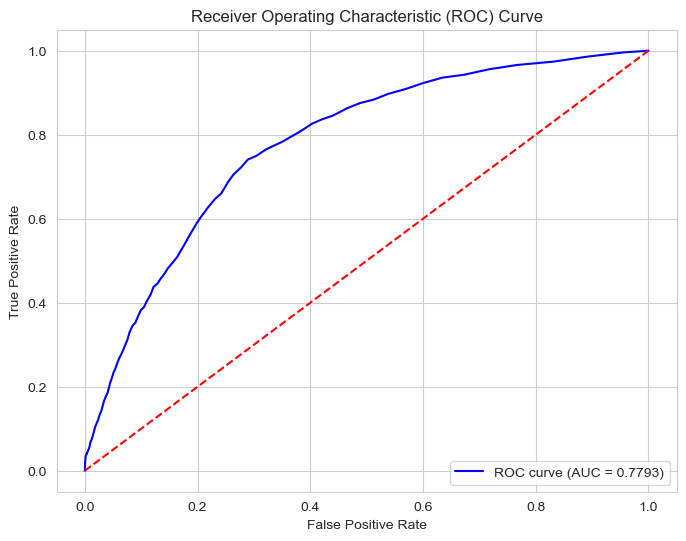

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Instantiate the classifier with n_estimators = 100
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the model
rfc_100.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc_100.predict(X_test)


# Accuracy score
print('Model accuracy score with 100 decision-trees: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Predicted probabilities for the positive class (class 1)
y_prob = rfc_100.predict_proba(X_test)[:, 1]

# AUC score
auc = roc_auc_score(y_test, y_prob)
print('AUC score: {0:0.4f}'.format(auc))

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='Yes' ) 

# Graph for ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {0:0.4f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




In [109]:
feature_scores = pd.Series(rfc_100.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

length_of_stay                   0.111871
purchase_lead                    0.089785
flight_hour                      0.087708
num_passengers                   0.084915
flight_day                       0.055653
                                   ...   
booking_origin_Nicaragua         0.000000
route_KBRWUH                     0.000000
booking_origin_Norfolk Island    0.000000
route_JEDPDG                     0.000000
route_CSXSYD                     0.000000
Length: 919, dtype: float64

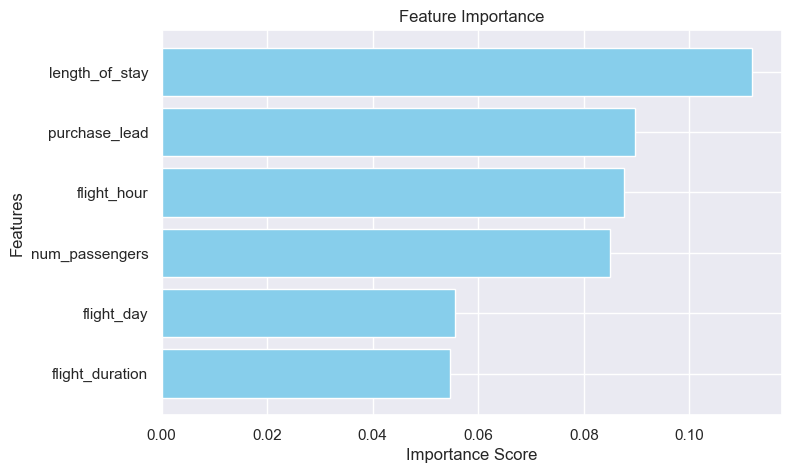

In [157]:
# feature importance plot
def plot_feature_score(feature_scores, top_n=6):
    sorted_scores = feature_scores.sort_values(ascending=False)
    
    # Select the top_n features
    top_scores = sorted_scores.head(top_n)
    
    # Sort the top_n features in ascending order for plotting
    top_scores_sorted = top_scores.sort_values(ascending=True)
    
    # Prepare data for plotting
    width = np.arange(len(top_scores_sorted))
    ticks = list(top_scores_sorted.index)
    
    # Plot
    plt.figure(dpi=100, figsize=(8, 5))
    plt.barh(width, top_scores_sorted, color='skyblue')
    plt.yticks(width, ticks)
    plt.title("Feature Importance")
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()


plot_feature_score(feature_scores)


# Random forest for top features identified in Mutual Information Analysis
- route
- booking_origin
- flight_duration
- length_of_stay
- wants_extra_baggage
- wants_in_flight_meals
- flight_hour
- purchase_lead
- flight_day


In [159]:
#feature to test
features = ['route', 'booking_origin', 'flight_duration', 'wants_extra_baggage', 'length_of_stay', 'wants_in_flight_meals', 'flight_hour', 'purchase_lead', 'flight_day']

# Find columns in the df that match the features list
matching_columns = [col for col in df.columns if any(col.startswith(feature) for feature in features)]

# Select the columns from the df
df_selected = df[matching_columns]


In [165]:
# declare feature vector and target variable and split data into training and testing.

X = df_selected

y = df['booking_complete']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

Model accuracy score with 100 decision-trees: 0.8497
AUC score: 0.7673
Precision: 0.81
Recall: 0.85
F1 Score: 0.81


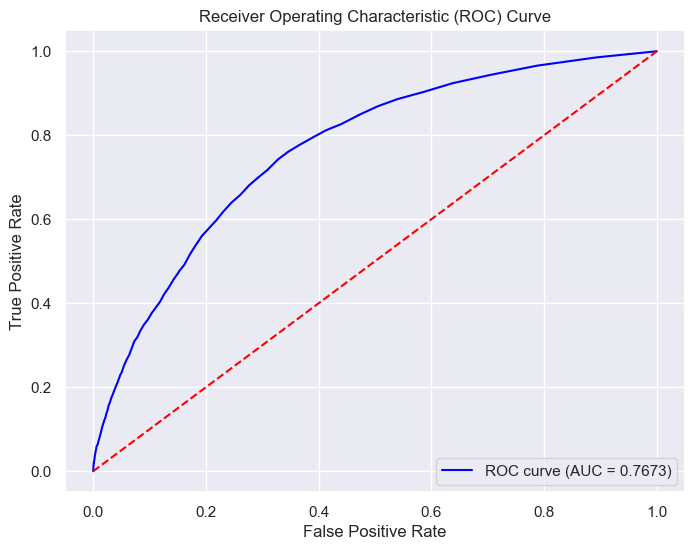

In [169]:
clf = RandomForestClassifier(random_state=0)

# fit the model to the training set

clf.fit(X_train, y_train)


# Predict on the test set results

y_pred = clf.predict(X_test)


# Accuracy score
print('Model accuracy score with 100 decision-trees: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')


# Predicted probabilities for the positive class (class 1)
y_prob = clf.predict_proba(X_test)[:, 1]

# AUC score
auc = roc_auc_score(y_test, y_prob)
print('AUC score: {0:0.4f}'.format(auc))

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='Yes' ) 

# Graph ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {0:0.4f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [171]:
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

purchase_lead              0.186462
flight_hour                0.151019
length_of_stay             0.126163
flight_day                 0.100273
flight_duration            0.034336
                             ...   
booking_origin_Slovakia    0.000000
route_SGNXIY               0.000000
route_CKGSGN               0.000000
booking_origin_Hungary     0.000000
route_MELNRT               0.000000
Length: 911, dtype: float64

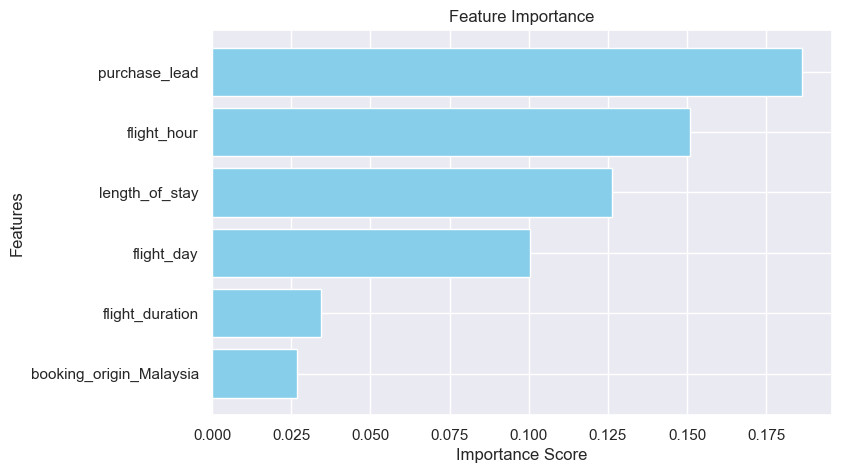

In [173]:
# feature importance plot
def plot_feature_score(feature_scores, top_n=6):
    sorted_scores = feature_scores.sort_values(ascending=False)
    
    # Select the top_n features
    top_scores = sorted_scores.head(top_n)
    
    # Sort the top_n features in ascending order for plotting
    top_scores_sorted = top_scores.sort_values(ascending=True)
    
    # Prepare data for plotting
    width = np.arange(len(top_scores_sorted))
    ticks = list(top_scores_sorted.index)
    
    # Plot
    plt.figure(dpi=100, figsize=(8, 5))
    plt.barh(width, top_scores_sorted, color='skyblue')
    plt.yticks(width, ticks)
    plt.title("Feature Importance")
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()


plot_feature_score(feature_scores)

# Findings
The **3 main features** that affect whether the booking will be completed are:
- **purchase_lead**(the number of days between travel date and booking date) 
- **flight_hour** (hour of flight departure) 
- **length_of_stay** (number of days spent at destination)

# Insights
- Bookings tend to happen more frequently closer to the travel date
- Travellers tend to prefer to book flights between 5 am and 3 pm.
- Travellers are more likely to book more for shorter trips.
  
# Suggestions
- Provide cheaper rates if travellers book 30 days in advance. Customers can also add a flexibility package for a small fee, allowing them to change the date and time if needed.
- Offer cheaper rates for people who travel in the late afternoon and evenings.
- Work in partnership with hotels to offer packages and deals for longer vacations.